# 十分钟强化学习第八讲：Deep Q-Network

### DQN的改进思路：
- 专门构造一个target network，缓解No-stationary target问题
- 使用经验缓冲数据进行训练，缓解No-IID问题

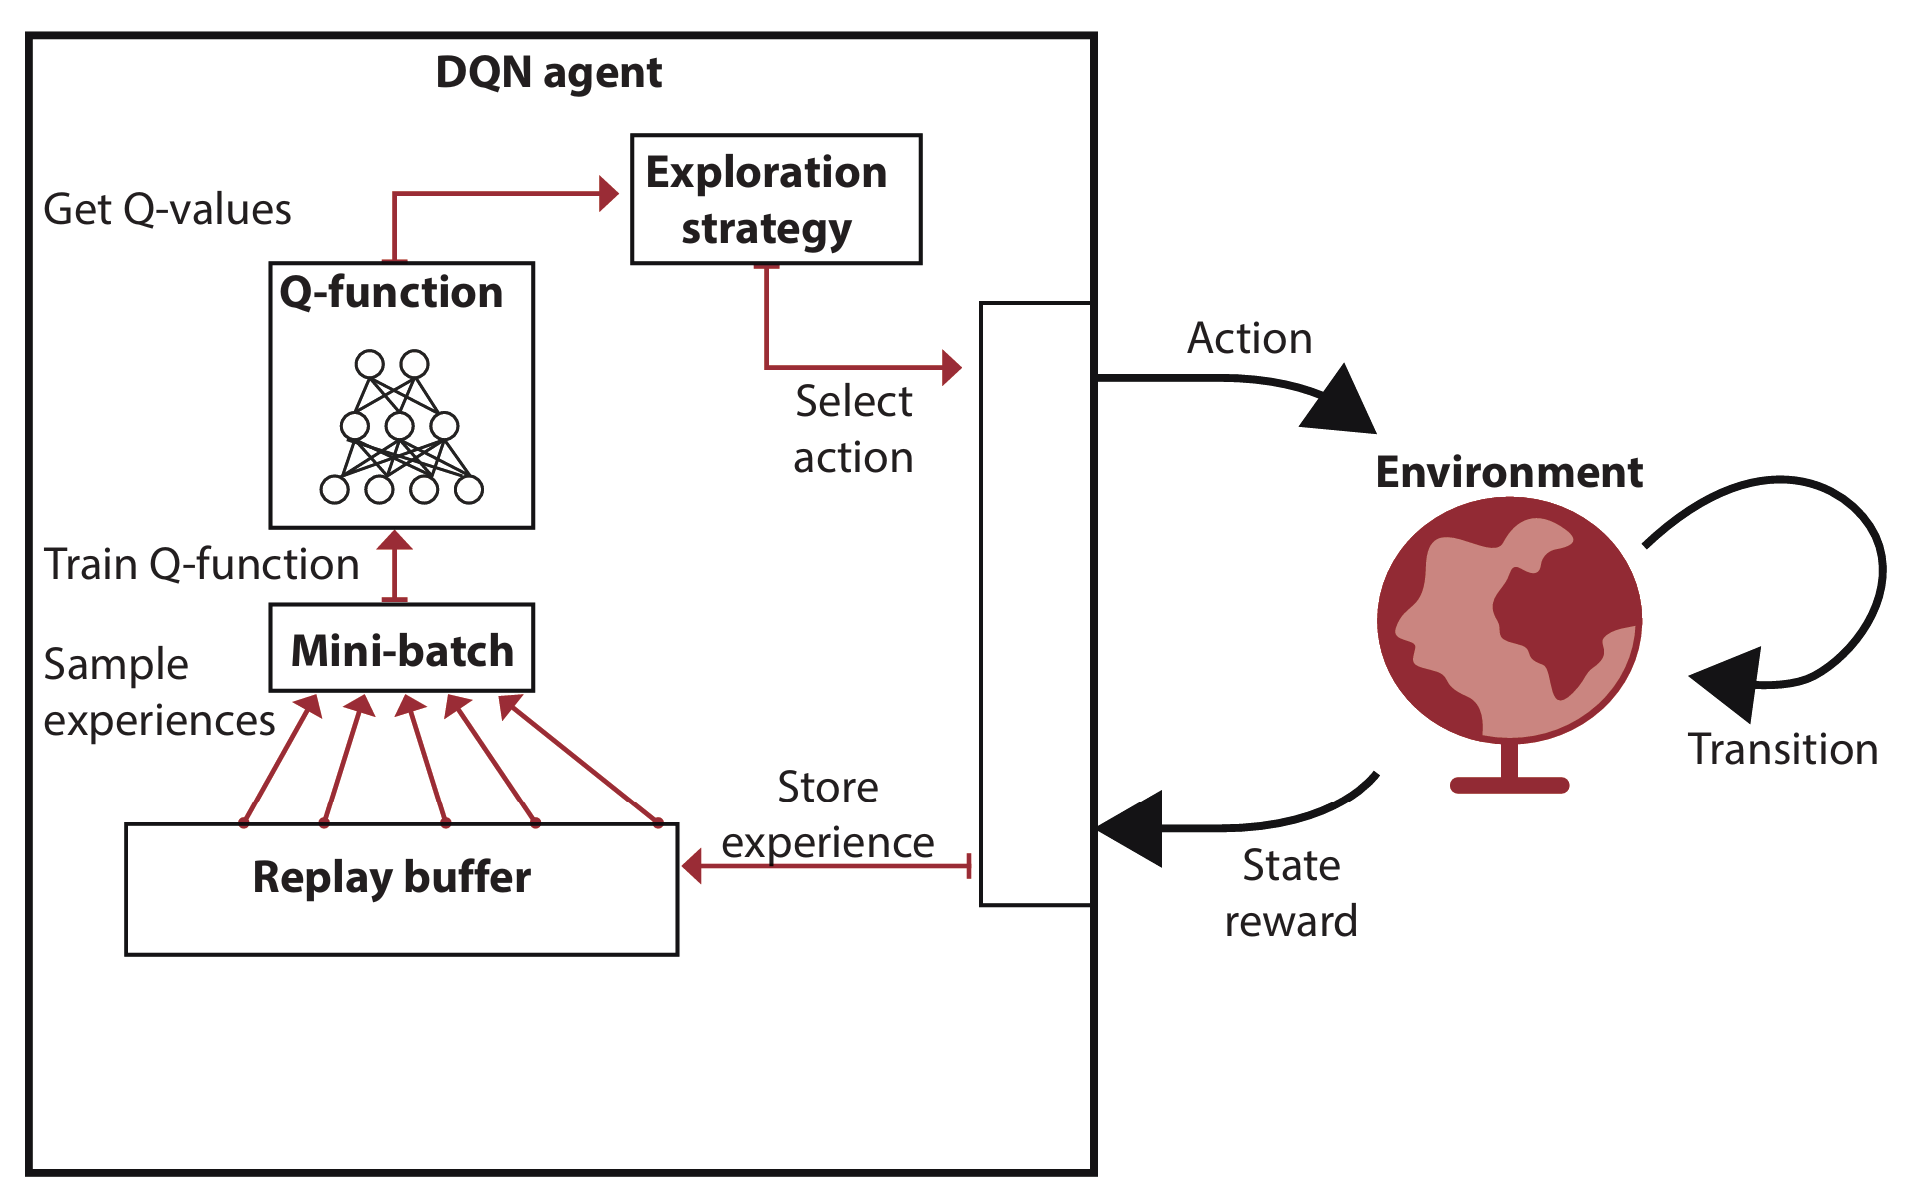

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import numpy as np
import random
from collections import deque

In [17]:
class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [18]:
class QTrainer:
    def __init__(self, lr, gamma,input_dim, hidden_dim, output_dim):
        self.gamma = gamma
        self.model = Linear_QNet(input_dim,hidden_dim,output_dim)
        self.target_model = Linear_QNet(input_dim,hidden_dim,output_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.SmoothL1Loss()
        self.copy_model()

    def copy_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        action = torch.unsqueeze(action, -1)
        reward = torch.tensor(reward, dtype=torch.float)
        done = torch.tensor(done, dtype=torch.long)

        Q_value = self.model(state).gather(-1, action).squeeze()
        Q_value_next = self.target_model(next_state).detach().max(-1)[0]
        target =  (reward + self.gamma * Q_value_next * (1 - done)).squeeze()

        self.optimizer.zero_grad()
        loss = self.criterion(Q_value,target)
        loss.backward()
        self.optimizer.step()

In [63]:
class Agent:
    def __init__(self,state_space, action_space, hidden_dim = 16, max_explore=1000, gamma = 0.9,
                max_memory=5000, lr=0.001):
        self.max_explore = max_explore 
        self.memory = deque(maxlen=max_memory) 
        self.nS = state_space  
        self.nA = action_space  
        self.step = 0
        self.n_game = 0
        self.trainer = QTrainer(lr, gamma, self.nS, hidden_dim,self.nA)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) 

    def train_long_memory(self,batch_size):
        if len(self.memory) > batch_size:
            mini_sample = random.sample(self.memory, batch_size) # list of tuples
        else:
            mini_sample = self.memory
        states, actions, rewards, next_states, dones = zip(*mini_sample)
        states = np.array(states)
        next_states = np.array(next_states)
        self.trainer.train_step(states, actions, rewards, next_states, dones)


    def get_action(self, state, n_game):
        state = torch.tensor(state, dtype=torch.float)
        prediction = self.trainer.model(state).detach().numpy().squeeze()
        
        epsilon = self.max_explore - n_game
        if random.randint(0, self.max_explore) < epsilon:
            final_move = np.random.randint(len(prediction))
        else:
            final_move = prediction.argmax()
        return final_move


    @staticmethod
    def one_hot(x,size):
        result = np.zeros(size)
        result[x] = 1
        return result 

In [64]:
def train(env, max_game=5000, max_step=100):
    nS = env.observation_space.n
    agent = Agent(state_space = env.observation_space.n, 
                action_space = env.action_space.n,
                hidden_dim=16,
                max_explore=1000, gamma = 0.9,
                max_memory=50000, lr=0.0005)
    results = []
    state_new, _ = env.reset()
    state_new = Agent.one_hot(state_new,nS)
    done = False
    total_step = 0
    while agent.n_game <= max_game:
        state_old = state_new
        action = agent.get_action(state_old, agent.n_game)
        state_new, reward, done, _, _ = env.step(action)
        state_new = Agent.one_hot(state_new,nS)
        agent.remember(state_old, action, reward, state_new, done)
        agent.train_long_memory(batch_size=256)
        agent.step += 1
        total_step += 1

        if total_step % 10 == 0:
            agent.trainer.copy_model()

        if done or agent.step>max_step:
            results.append(reward>0)
            state_new, _ = env.reset()
            state_new = Agent.one_hot(state_new,nS)
            agent.step = 0
            agent.n_game += 1

            if (agent.n_game>0) and (agent.n_game % 200 ==0):         
                print("Running episode  {}, step {} Reaches goal {:.2f}%. ".format(
                    agent.n_game, total_step,np.sum(results[-100:])))



In [65]:
env = gym.make('FrozenLake-v1',map_name="8x8")
train(env, 4000)

Running episode  200, step 6278 Reaches goal 1.00%. 
Running episode  400, step 13070 Reaches goal 0.00%. 
Running episode  600, step 21277 Reaches goal 5.00%. 
Running episode  800, step 30177 Reaches goal 12.00%. 
Running episode  1000, step 40508 Reaches goal 35.00%. 
Running episode  1200, step 52212 Reaches goal 41.00%. 
Running episode  1400, step 63518 Reaches goal 44.00%. 
Running episode  1600, step 75377 Reaches goal 42.00%. 
Running episode  1800, step 86564 Reaches goal 34.00%. 
Running episode  2000, step 97992 Reaches goal 41.00%. 
Running episode  2200, step 109206 Reaches goal 36.00%. 
Running episode  2400, step 121477 Reaches goal 30.00%. 
Running episode  2600, step 133133 Reaches goal 42.00%. 
Running episode  2800, step 144547 Reaches goal 36.00%. 
Running episode  3000, step 155805 Reaches goal 43.00%. 
Running episode  3200, step 168362 Reaches goal 37.00%. 
Running episode  3400, step 180132 Reaches goal 48.00%. 
Running episode  3600, step 192108 Reaches goal 4